# Importing Libraries

In [1]:
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt
import datetime
import seaborn as sns

In [2]:
%run "Stock Data.ipynb".ipynb
%run "Binance API.ipynb".ipynb
%run "RiskMetrics.ipynb".ipynb

# Importing Data

## Tickers

In [3]:
binance_api_key='E90xR7UnO2oeP3lrgC50zkqUuAqyyXs4uSlAGcqIVO9n90ELrFI4gfVI2HGGxxCj'
binance_api_secret='Inls2xYl9FqPi0zlIrucfxG81drx7w6Pv6SzYFxMNoAcwDjlCKug7zUM9zB3lF9h'
Binance=BinanceAPI(binance_api_key,binance_api_secret)

In [4]:
#stocks=pd.read_html('https://en.wikipedia.org/wiki/EURO_STOXX_50')[4]
#tickers=stocks['Ticker'].to_list()

## Market Data

In [5]:
start_date=datetime.datetime(2023,12,1)
enddate=start_date+datetime.timedelta(500)

In [6]:
tickers=Binance.get_market_cap()['Ticker'].iloc[:75].to_list()
holding=Binance.get_inventory()
condition=holding.index!='Total'
holding_tickers=holding.index[condition]
holding_tickers=holding_tickers.to_list()
tickers=sorted(list(set(tickers+holding_tickers)))
holding.round(5)

,Price in USDT,Weights in %
Total,1777.31466,1.00000
BTCUSDT,601.20300,0.33826
TRXUSDT,278.58183,0.15674
SOLUSDT,241.65611,0.13597
JASMYUSDT,240.76241,0.13546
OMUSDT,205.77462,0.11578
ETHUSDT,176.04499,0.09905
BBUSDT,33.27061,0.01872
BNBUSDT,0.02110,0.00001
PEPEUSDT,0.00000,0.00000


In [7]:
data1=Binance.get_price(tickers,start_date)
data2=Binance.get_price(tickers,enddate)
data=data1.combine_first(data2)
data.index=pd.to_datetime(data.index)
#data=data.dropna(axis=1)
n=len(data.columns)
data=data.sort_index()

In [8]:
inventory_weights=(holding['Weights in %'].apply(lambda x: np.round(x,2))).to_dict()
inventory_weights.pop('Total')

if "USDTUSDT" in inventory_weights:
    
    inventory_weights.pop('USDTUSDT')
else: 
    pass

In [9]:
returns=np.log(1+data.pct_change())
returns.index=pd.to_datetime(returns.index)
with_no_na=returns.columns[np.where((returns.isna().sum()<30))]
returns_to_use=returns[with_no_na]
ex_ante_perf=returns[holding_tickers]
ex_ante_perf_to_use=ex_ante_perf.dropna()

In [10]:
weights_post=dict()

for col in ex_ante_perf.columns:
    
    if col in inventory_weights.keys():
        weights_post[col]=inventory_weights[col]
        
    else:
        weights_post[col]=0
    
current_weights=np.array(list(weights_post.values()))
current_weights=np.round(current_weights,2)/np.sum(np.round(current_weights,2))

### Positions

In [11]:
position=pd.read_excel('Positions.xlsx',index_col=0)

In [12]:
positions=Binance.get_positions_history(enddate=datetime.datetime.today(),
                                        startdate=datetime.datetime(2024,5,5))


2024-05-05 00:00:00
2024-06-04 00:00:00
2024-07-04 00:00:00
2024-08-03 00:00:00
2024-09-02 00:00:00
LDUMAUSDT not retrieved
LDTRXUSDT not retrieved
LDUMAUSDT
LDTRXUSDT


In [13]:
positions=positions.sort_index()

In [14]:
positions.index=pd.to_datetime(positions.index)

In [15]:
positions=pd.concat([position,positions])
positions=positions.loc[~positions.index.duplicated(),:]

In [16]:
positions.to_excel('Positions.xlsx')

In [17]:
positions=positions.interpolate()
positions['Total']=positions.sum(axis=1)

In [18]:
ptf_tickers=list(positions.columns)
ptf_tickers.remove('USDTUSDT')

In [19]:
weights_ex_post=positions.copy()
weights_ex_post=weights_ex_post.drop(columns=['USDTUSDT'])
weights_ex_post=weights_ex_post.apply(lambda x: x/weights_ex_post['Total'])

In [20]:
binance_data=Binance.get_price(ptf_tickers,date=datetime.datetime(2024,5,11))
binance_data.index=pd.to_datetime(binance_data.index)
binance_data=binance_data.sort_index()
binance_data=np.log(1+binance_data.pct_change())


LDUMAUSDT not retrieved
Total not retrieved


In [21]:
weight_date=set(weights_ex_post.index)
binance_date=binance_data.index

In [22]:
common_date=binance_date.intersection(weight_date)

binance_data=binance_data.loc[common_date]

In [23]:
historical_ptf=pd.DataFrame()

for col in binance_data:
    historical_ptf[col]=weights_ex_post[col]*binance_data[col]
    
historical_ptf['Historical Portfolio']=historical_ptf.sum(axis=1)

<AxesSubplot:>

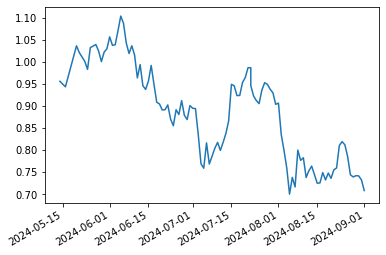

In [24]:
#historical_ptf.dropna(axis = 0, how = 'all', inplace = True)

(1+historical_ptf['Historical Portfolio']).cumprod().plot()

### Ex ante data

In [25]:
ex_ante_ptf=ex_ante_perf.copy()

for key in inventory_weights.keys():
    
    ex_ante_ptf[key]=ex_ante_perf[key]*inventory_weights[key]

ex_ante_ptf=pd.DataFrame(ex_ante_ptf.sum(axis=1))

# Portfolio Optimization

In [26]:
historical_risk=RiskAnalysis(returns_to_use)
current_risk=RiskAnalysis(ex_ante_perf_to_use.iloc[:])
num_asset=len(returns_to_use.columns)
num_asset_current=len(ex_ante_perf_to_use.columns)

In [27]:
returns_to_use.columns

Index(['1000SATSUSDT', 'AAVEUSDT', 'ADAUSDT', 'ALGOUSDT', 'APTUSDT', 'ARBUSDT',
       'ARUSDT', 'ATOMUSDT', 'AVAXUSDT', 'AXSUSDT', 'BCHUSDT', 'BNBUSDT',
       'BONKUSDT', 'BTCUSDT', 'DOGEUSDT', 'DOTUSDT', 'EGLDUSDT', 'EOSUSDT',
       'ETCUSDT', 'ETHUSDT', 'FDUSDUSDT', 'FETUSDT', 'FILUSDT', 'FLOKIUSDT',
       'FLOWUSDT', 'FTMUSDT', 'GALAUSDT', 'GRTUSDT', 'HBARUSDT', 'ICPUSDT',
       'IMXUSDT', 'INJUSDT', 'JASMYUSDT', 'LDOUSDT', 'LINKUSDT', 'LTCUSDT',
       'MATICUSDT', 'MKRUSDT', 'NEARUSDT', 'NEOUSDT', 'OMUSDT', 'OPUSDT',
       'ORDIUSDT', 'PEPEUSDT', 'QNTUSDT', 'RUNEUSDT', 'SANDUSDT', 'SEIUSDT',
       'SHIBUSDT', 'SOLUSDT', 'STXUSDT', 'SUIUSDT', 'THETAUSDT', 'TIAUSDT',
       'TRXUSDT', 'UNIUSDT', 'USDCUSDT', 'VETUSDT', 'WBETHUSDT', 'WBTCUSDT',
       'WLDUSDT', 'XECUSDT', 'XLMUSDT', 'XRPUSDT', 'XTZUSDT'],
      dtype='object')

In [28]:
limit=np.where(returns_to_use.columns=='BTCUSDT')[0][0],np.where(returns_to_use.columns=='ETHUSDT')[0][0],np.where(returns_to_use.columns=='SOLUSDT')[0][0]

## Optimal Portfolio

In [29]:
opt_weights=historical_risk.optimize(objective="sharpe_ratio",constraints=[{'type': 'ineq', 'fun': lambda weights: weights[limit[0]]-0.40}])
                                                         #  ,{'type': 'ineq', 'fun': lambda weights: weights[limit[1]]-0.15},
                                                        #{'type': 'ineq', 'fun': lambda weights: weights[limit[2]]-0.15}])
opt_weights=np.round(opt_weights,6)
inventory=historical_risk.inventory(opt_weights)
inventory

,Weights
OMUSDT,0.486542
BTCUSDT,0.400000
PEPEUSDT,0.066234
BNBUSDT,0.041222
JASMYUSDT,0.006002


In [30]:
limit=np.where(ex_ante_perf_to_use.columns=='BTCUSDT')[0][0],np.where(ex_ante_perf_to_use.columns=='ETHUSDT')[0][0],np.where(ex_ante_perf_to_use.columns=='SOLUSDT')[0][0]

In [31]:
current_optimal_weights=current_risk.optimize(objective="sharpe_ratio")#,constraints=[{'type': 'ineq', 'fun': lambda weights: weights[limit[0]]-0.40}])
                                                           #,{'type': 'ineq', 'fun': lambda weights: weights[limit[1]]-0.15},
                                                            #{'type': 'ineq', 'fun': lambda weights: weights[limit[2]]-0.15}])
current_optimal_weights=np.round(current_optimal_weights,6)
optimal_ptf_current=current_risk.inventory(current_optimal_weights)
optimal_ptf_current

,Weights
TRXUSDT,0.844436
OMUSDT,0.155564


## Real Portfolio vs Optimal

In [32]:
current_holding_comparison=holding.copy()
current_holding_comparison=current_holding_comparison.loc[current_holding_comparison.index!="Total"]
current_holding_comparison=pd.concat([current_holding_comparison,optimal_ptf_current],axis=1)
current_holding_comparison['Spread']=current_holding_comparison['Weights in %']-current_holding_comparison['Weights']
current_holding_comparison=current_holding_comparison.fillna(0)
current_holding_comparison

,Price in USDT,Weights in %,Weights,Spread
BTCUSDT,601.203000,3.382648e-01,0.000000,0.000000
TRXUSDT,278.581826,1.567431e-01,0.844436,-0.687693
SOLUSDT,241.656105,1.359670e-01,0.000000,0.000000
JASMYUSDT,240.762412,1.354641e-01,0.000000,0.000000
OMUSDT,205.774616,1.157784e-01,0.155564,-0.039786
ETHUSDT,176.044993,9.905111e-02,0.000000,0.000000
BBUSDT,33.270605,1.871959e-02,0.000000,0.000000
BNBUSDT,0.021099,1.187134e-05,0.000000,0.000000
PEPEUSDT,0.000002,1.024917e-09,0.000000,0.000000


In [33]:
historical_comparison=holding.copy()
historical_comparison=historical_comparison.loc[historical_comparison.index!="Total"]
historical_comparison=pd.concat([historical_comparison,inventory],axis=1)
historical_comparison['Spread']=historical_comparison['Weights in %']-historical_comparison['Weights']
historical_comparison=historical_comparison.fillna(0)
historical_comparison

,Price in USDT,Weights in %,Weights,Spread
BTCUSDT,601.203000,3.382648e-01,0.400000,-0.061735
TRXUSDT,278.581826,1.567431e-01,0.000000,0.000000
SOLUSDT,241.656105,1.359670e-01,0.000000,0.000000
JASMYUSDT,240.762412,1.354641e-01,0.006002,0.129462
OMUSDT,205.774616,1.157784e-01,0.486542,-0.370764
ETHUSDT,176.044993,9.905111e-02,0.000000,0.000000
BBUSDT,33.270605,1.871959e-02,0.000000,0.000000
BNBUSDT,0.021099,1.187134e-05,0.041222,-0.041210
PEPEUSDT,0.000002,1.024917e-09,0.066234,-0.066234


## Risk Reward Analysis

In [34]:
opt_ptf=(returns_to_use*opt_weights).sum(axis=1)
curr_opt_ptf=(ex_ante_perf*current_optimal_weights).sum(axis=1)
portfolio_perf=pd.DataFrame()
portfolio_perf['Portfolio']=(ex_ante_perf*current_weights).sum(axis=1)

In [35]:
portfolio_perf['Bitcoin']=returns['BTCUSDT']
portfolio_perf['Optimal']=opt_ptf
portfolio_perf['Current Optimal']=curr_opt_ptf

<AxesSubplot:>

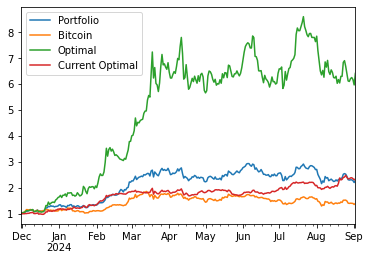

In [36]:
(1+portfolio_perf.iloc[:]).cumprod().plot()

In [37]:
current_perf=portfolio_perf.copy()
current_perf=current_perf.loc[historical_ptf.index]
current_perf['Historical Portfolio']=historical_ptf['Historical Portfolio']

<AxesSubplot:>

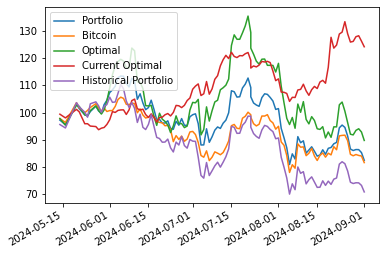

In [38]:
((1+current_perf.iloc[:]).cumprod()*100).plot()

In [39]:
((1+current_perf).cumprod()*100).iloc[-10:]

,Portfolio,Bitcoin,Optimal,Current Optimal,Historical Portfolio
2024-08-23,94.416608,91.447904,102.844150,128.800094,81.091030
2024-08-24,95.408768,91.618781,103.849001,129.490660,81.956249
2024-08-25,94.554509,91.708689,100.520173,133.326266,81.245356
2024-08-26,91.387640,89.707756,96.310567,128.914611,78.568301
2024-08-27,86.627064,84.688642,92.059066,125.852451,74.455873
2024-08-28,86.073287,84.145117,91.801802,126.090352,73.972108
2024-08-29,86.434571,84.605822,93.462844,127.817834,74.250621
2024-08-30,86.403792,84.270178,94.056462,128.170361,74.210191
2024-08-31,85.309918,84.056109,92.859575,126.199284,73.287799
2024-09-01,82.493663,81.638368,89.765692,124.129516,70.888670


<AxesSubplot:>

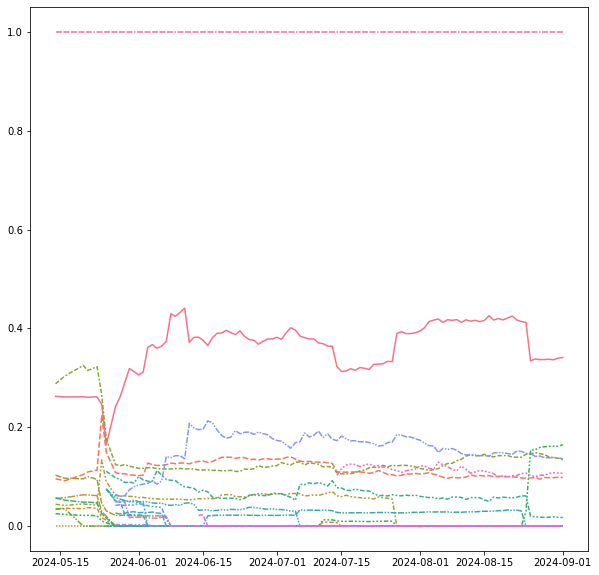

In [40]:
plt.figure(figsize=(10,10))
sns.lineplot(data=weights_ex_post,legend=False,linestyle='solid')

In [41]:
vol=historical_risk.portfolio(opt_weights).std()*np.sqrt(252)

vol

Portfolio    0.757387
dtype: float64

In [42]:
vol=current_risk.portfolio(current_weights).std()*np.sqrt(252)

vol

Portfolio    0.493275
dtype: float64

In [43]:
portfolio_perf.iloc[1:].std()*np.sqrt(252)

Portfolio          0.487901
Bitcoin            0.450592
Optimal            0.758721
Current Optimal    0.353761
dtype: float64

In [44]:
current_risk.tracking_error(current_risk.returns['BTCUSDT'],current_perf['Historical Portfolio'])

0.26123400293803684

In [45]:
perf_analysis=pd.concat([historical_risk.perf_contrib_pct(opt_weights),historical_risk.var_contrib_pct(opt_weights)],axis=1)
perf_analysis

,Performance Contribution in %,Last Weights,Variance Contribution in %,Idiosyncratic Risk in %,Correlation in %
BNBUSDT,0.005029,0.008920,0.011417,0.000750,0.010667
BTCUSDT,0.019376,0.060295,0.147626,0.056432,0.091194
JASMYUSDT,0.000718,0.001286,0.003045,0.000079,0.002966
OMUSDT,0.960713,0.909737,0.786019,0.693124,0.092895
PEPEUSDT,0.014164,0.019762,0.051893,0.013458,0.038435


In [46]:
perf_analysis=pd.concat([current_risk.perf_contrib_pct(current_weights),current_risk.var_contrib_pct(current_weights)],axis=1)
perf_analysis

,Performance Contribution in %,Last Weights,Variance Contribution in %,Idiosyncratic Risk in %,Correlation in %
BTCUSDT,0.520255,0.320787,0.265122,0.084547,0.180575
TRXUSDT,-0.495550,0.200655,0.039251,0.010781,0.028470
SOLUSDT,0.390302,0.120269,0.169646,0.038192,0.131454
JASMYUSDT,0.420347,0.118253,0.246438,0.085706,0.160731
OMUSDT,-0.336129,0.148106,0.145146,0.045029,0.100117
ETHUSDT,0.309034,0.083876,0.093841,0.012885,0.080955
BBUSDT,0.191740,0.008054,0.040557,0.003696,0.036861


## Value At Risk

### Historical

In [47]:
var,cvar=historical_risk.historical_var(opt_weights)
(var,cvar)

(-0.06305372539177972, -0.08941388645850742)

In [48]:
var,cvar=current_risk.historical_var(current_weights)
(var,cvar)

(-0.051129940134204445, -0.0649274161711948)

In [49]:
historical_var=current_risk.returns*current_weights
historical_var['Portfolio']=historical_var.sum(axis=1)
historical_var=historical_var.sort_values(by='Portfolio')
centile=0.05
row=round(historical_var.shape[0]*centile)

In [50]:
var=historical_var.iloc[row]
var

BTCUSDT     -0.012322
TRXUSDT     -0.001710
SOLUSDT     -0.011560
JASMYUSDT   -0.010997
OMUSDT      -0.009695
ETHUSDT     -0.002070
BBUSDT      -0.001988
BNBUSDT     -0.000000
PEPEUSDT    -0.000000
Portfolio   -0.050343
Name: 2024-08-11 00:00:00, dtype: float64

In [51]:
cvar=historical_var.iloc[:row+1].mean()
cvar

BTCUSDT     -0.016934
TRXUSDT     -0.003874
SOLUSDT     -0.010790
JASMYUSDT   -0.013847
OMUSDT      -0.009044
ETHUSDT     -0.006300
BBUSDT      -0.002055
BNBUSDT      0.000000
PEPEUSDT     0.000000
Portfolio   -0.062844
dtype: float64

### Parametric

In [52]:
var,cvar=historical_risk.parametric_var(opt_weights)

(var,cvar)

(-0.0786156738764469, -0.10076355787959039)

In [53]:
var,cvar=current_risk.parametric_var(current_weights)

(var,cvar)

(-0.05111115412938617, -0.0655103681424022)

### Multivariate

In [54]:
perf=performance(historical_risk.multivariate_distribution(),opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()
(var,cvar)

(-0.07040007260410838, -0.09012228660147618)

In [55]:
perf=performance(current_risk.multivariate_distribution(),current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()
(var,cvar)

(-0.05093682389462956, -0.06436882752828102)

In [56]:
scenario_multivariate={}

for i in range(50):
    multivariate_distrib=pd.DataFrame(current_risk.multivariate_distribution(),columns=current_risk.returns.columns)
    multivariate_distrib=multivariate_distrib*current_weights
    multivariate_distrib=multivariate_distrib[multivariate_distrib.columns[current_weights>0]]

    multivariate_distrib['Portfolio']=multivariate_distrib.sum(axis=1)
    multivariate_var=multivariate_distrib.sort_values(by='Portfolio').iloc[int(multivariate_distrib.shape[0]*0.05)]['Portfolio']
    results=multivariate_distrib.sort_values(by='Portfolio').iloc[int(multivariate_distrib.shape[0]*0.05)]

    scenario_multivariate[i]=results.to_dict()

mean_scenario_multivariate=pd.DataFrame(scenario_multivariate).T.mean()
mean_scenario_multivariate

BTCUSDT     -0.013114
TRXUSDT     -0.001864
SOLUSDT     -0.008629
JASMYUSDT   -0.012975
OMUSDT      -0.007087
ETHUSDT     -0.004926
BBUSDT      -0.002176
Portfolio   -0.050771
dtype: float64

### Copulas

In [57]:
cop=historical_risk.gaussian_copula()
perf=performance(cop,opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.06932279925805332, -0.08980426723048494)

In [58]:
cop=current_risk.gaussian_copula()
perf=performance(cop,current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.050395764744947745, -0.06271791425777308)

In [59]:
scenario_gaussian={}

for i in range(100):
    gaussian_copula_distrib=pd.DataFrame(current_risk.gaussian_copula(),columns=current_risk.returns.columns)

    gaussian_copula_distrib=gaussian_copula_distrib*current_weights
    gaussian_copula_distrib=gaussian_copula_distrib[gaussian_copula_distrib.columns[current_weights>0]]

    gaussian_copula_distrib['Portfolio']=gaussian_copula_distrib.sum(axis=1)
    gaussian_var=gaussian_copula_distrib.sort_values(by='Portfolio').iloc[int(gaussian_copula_distrib.shape[0]*0.05)]['Portfolio']
    results=gaussian_copula_distrib.sort_values(by='Portfolio').iloc[int(gaussian_copula_distrib.shape[0]*0.05)]
    
    scenario_gaussian[i]=results
    
mean_scenario_gaussian=pd.DataFrame(scenario_gaussian).T.mean()
mean_scenario_gaussian

BTCUSDT     -0.013875
TRXUSDT     -0.002008
SOLUSDT     -0.008859
JASMYUSDT   -0.011977
OMUSDT      -0.007078
ETHUSDT     -0.004881
BBUSDT      -0.002209
Portfolio   -0.050888
dtype: float64

In [60]:
t_copula=historical_risk.t_copula()
perf=performance(t_copula,opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.06939779708097618, -0.08812808752886586)

In [61]:
t_copula=current_risk.t_copula()
perf=performance(t_copula,current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.052543235933154395, -0.06522239999888009)

In [62]:
scenario_t_copula={}

for i in range(100):
    
    t_copula_distrib=pd.DataFrame(current_risk.t_copula(),columns=current_risk.returns.columns)
    t_copula_distrib=t_copula_distrib*current_weights
    t_copula_distrib=t_copula_distrib[t_copula_distrib.columns[current_weights>0]]
    t_copula_distrib['Portfolio']=t_copula_distrib.sum(axis=1)
    t_copula_var=t_copula_distrib.sort_values(by='Portfolio').iloc[int(t_copula_distrib.shape[0]*0.05)]['Portfolio']
    results=t_copula_distrib.sort_values(by='Portfolio').iloc[int(t_copula_distrib.shape[0]*0.05)]
    
    scenario_t_copula[i]=results
    
mean_scenario_gaussian=pd.DataFrame(scenario_t_copula).T.mean()
mean_scenario_gaussian

BTCUSDT     -0.013942
TRXUSDT     -0.001914
SOLUSDT     -0.008842
JASMYUSDT   -0.012634
OMUSDT      -0.007378
ETHUSDT     -0.004938
BBUSDT      -0.002239
Portfolio   -0.051887
dtype: float64

In [63]:
gumbel_copula=historical_risk.gumbel_copula()
perf=performance(gumbel_copula,opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.14580197088519584, -0.20450680776781752)

In [64]:
gumbel_copula=current_risk.gumbel_copula(theta=2)
perf=performance(gumbel_copula,current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.05597103122352153, -0.07453029878648695)

In [65]:
scenario_gumbel_copula={}

for i in range(100):
    
    gumbel_copula_distrib=pd.DataFrame(current_risk.gumbel_copula(),columns=current_risk.returns.columns)
    gumbel_copula_distrib=gumbel_copula_distrib*current_weights
    gumbel_copula_distrib=gumbel_copula_distrib[gumbel_copula_distrib.columns[current_weights>0]]
    gumbel_copula_distrib['Portfolio']=gumbel_copula_distrib.sum(axis=1)
    gumbel_copula_var=gumbel_copula_distrib.sort_values(by='Portfolio').iloc[int(gumbel_copula_distrib.shape[0]*0.05)]['Portfolio']
    results=gumbel_copula_distrib.sort_values(by='Portfolio').iloc[int(gumbel_copula_distrib.shape[0]*0.05)]
    
    scenario_gumbel_copula[i]=results
    
mean_scenario_gaussian=pd.DataFrame(scenario_gumbel_copula).T.mean()
mean_scenario_gaussian

BTCUSDT     -0.015492
TRXUSDT     -0.000749
SOLUSDT     -0.007454
JASMYUSDT   -0.021102
OMUSDT      -0.008337
ETHUSDT     -0.003154
BBUSDT      -0.000383
Portfolio   -0.056670
dtype: float64

### Monte Carlo

In [66]:
spot=data[with_no_na].iloc[-1]
monte_carlo=historical_risk.monte_carlo(spot,horizon=1/250,stress_factor=1.0)
perf=performance(monte_carlo[1].fillna(0),opt_weights)

In [67]:
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.08117188759887128, -0.10168152376233604)

In [68]:
spot=data[ex_ante_perf.columns].iloc[-1]
monte_carlo=current_risk.monte_carlo(spot,horizon=1/250,stress_factor=1.0)
perf=performance(monte_carlo[1].fillna(0),current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.051258344171446264, -0.06443830238861745)

In [69]:
spot=data[ex_ante_perf.columns].iloc[-1]

scenario_monte_carlo={}

for i in range(100):
    
    monte_carlo=current_risk.monte_carlo(spot,horizon=1/250,stress_factor=1.0)
    monte_carlo_distrib=monte_carlo[1].fillna(0)*current_weights
    monte_carlo_distrib=monte_carlo_distrib[monte_carlo_distrib.columns[current_weights>0]]
    monte_carlo_distrib['Portfolio']=monte_carlo_distrib.sum(axis=1)
    monte_carlo_var=monte_carlo_distrib.sort_values(by='Portfolio').iloc[int(monte_carlo_distrib.shape[0]*0.05)]['Portfolio']
    results=monte_carlo_distrib.sort_values(by='Portfolio').iloc[int(monte_carlo_distrib.shape[0]*0.05)]
    
    scenario_monte_carlo[i]=results
    
mean_scenario_monte_carlo=pd.DataFrame(scenario_monte_carlo).T.mean()
mean_scenario_monte_carlo

BTCUSDT     -0.014158
TRXUSDT     -0.002250
SOLUSDT     -0.009343
JASMYUSDT   -0.012377
OMUSDT      -0.006948
ETHUSDT     -0.005062
BBUSDT      -0.002051
Portfolio   -0.052189
dtype: float64

### VaR Violation

In [70]:
var_data=rolling_var(returns_to_use,opt_weights,window=30,Q=1)
var_data

,Historical,Parametric,Multivariate,Portfolio
2024-01-14,-0.060746,-0.109056,-0.089681,-0.024602
2024-01-15,-0.060746,-0.109051,-0.092287,0.016647
2024-01-16,-0.060746,-0.109730,-0.089475,0.061080
2024-01-17,-0.060746,-0.112125,-0.095643,-0.035947
2024-01-18,-0.060746,-0.114160,-0.095089,-0.034051
...,...,...,...,...
2024-08-29,-0.068909,-0.095265,-0.104391,0.018094
2024-08-30,-0.068909,-0.095220,-0.105427,0.006351
2024-08-31,-0.068909,-0.094109,-0.101225,-0.012725
2024-09-01,-0.060596,-0.090581,-0.097015,-0.033318


In [71]:
current_var_data=rolling_var(ex_ante_perf_to_use,current_weights,window=15,Q=1)
current_var_data

,Historical,Parametric,Multivariate,Portfolio
2024-05-28,-0.027136,-0.077276,-0.069154,-0.017206
2024-05-29,-0.023656,-0.074812,-0.067800,-0.008638
2024-05-30,-0.023656,-0.064444,-0.062143,0.032466
2024-05-31,-0.023656,-0.062986,-0.055337,0.015319
2024-06-01,-0.023656,-0.062916,-0.053565,0.026722
...,...,...,...,...
2024-08-29,-0.049488,-0.062160,-0.062171,0.004197
2024-08-30,-0.049488,-0.060588,-0.059558,-0.000356
2024-08-31,-0.049488,-0.061198,-0.059442,-0.012660
2024-09-01,-0.049488,-0.062699,-0.064227,-0.033012


<AxesSubplot:>

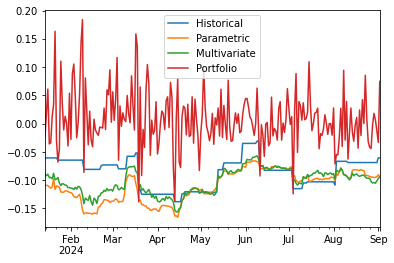

In [72]:
var_data.plot()

<AxesSubplot:>

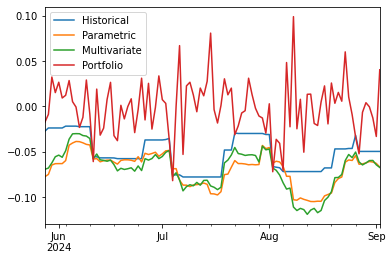

In [73]:
current_var_data.plot()

In [74]:
kupiec_test(var_data)

,Historical,Parametric,Multivariate
Proportion of failure,0.021459,0.012876,0.012876
Kupiec Stat,5.039132,9.493546,9.493546
P-value,0.024781,0.002062,0.002062


In [75]:
kupiec_test(current_var_data)

,Historical,Parametric,Multivariate
Proportion of failure,0.081633,0.040816,0.030612
Kupiec Stat,1.747689,0.185146,0.894777
P-value,0.186168,0.666988,0.344186


## Principal Component Analysis

In [76]:
eigval,eigvec,portfolio_components=historical_risk.pca(num_components=5)
variance_explained=eigval/eigval.sum()
variance_explained

array([0.78424833, 0.06623286, 0.05454119, 0.04937898, 0.04559864])

In [77]:
eigval,eigvec,portfolio_components_current=current_risk.pca(num_components=5)
variance_explained=eigval/eigval.sum()
variance_explained

array([0.67007406, 0.14007363, 0.08447528, 0.07318598, 0.03219105])

In [78]:
pca_weight=dict((portfolio_components_current['PC1']/portfolio_components_current['PC1'].sum()))
portfolio_components_current['PC1']

BTCUSDT      0.062408
TRXUSDT      0.015153
SOLUSDT      0.101838
JASMYUSDT    0.156892
OMUSDT       0.099110
ETHUSDT      0.084750
BBUSDT       0.249685
BNBUSDT      0.068824
PEPEUSDT     0.161338
Name: PC1, dtype: float64

<AxesSubplot:>

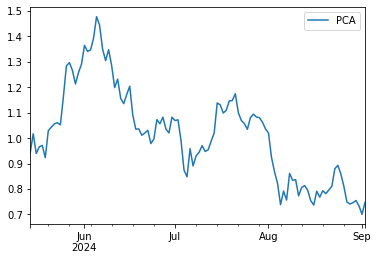

In [79]:
PCA=pd.DataFrame(np.array(list(pca_weight.values())).dot(np.transpose(current_risk.returns)),
                 index=current_risk.returns.index,
                 columns=['PCA'])
PCA=PCA.dropna()
(1+PCA).cumprod().plot()

<AxesSubplot:>

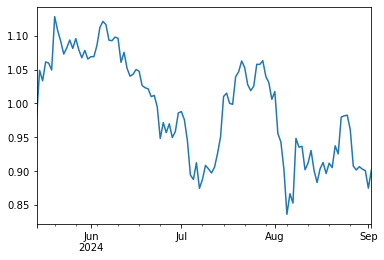

In [80]:
(1+current_risk.returns['BTCUSDT']).cumprod().plot()

In [81]:
comparison=current_risk.returns.copy()
comparison['PCA']=PCA
distances=np.sqrt(np.sum(comparison.apply(lambda y:(y-PCA['PCA'])**2))).sort_values()
distances.index[:5]

Index(['PCA', 'ETHUSDT', 'SOLUSDT', 'BNBUSDT', 'BTCUSDT'], dtype='object')

<AxesSubplot:>

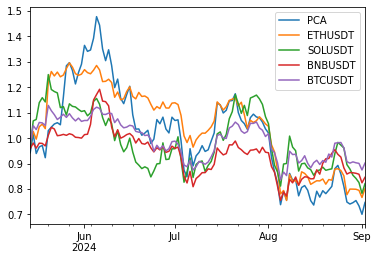

In [82]:
(1+comparison[distances.index[:5]]).cumprod().plot()

### Sensitivity Analysis

In [83]:
beta=(ex_ante_perf.cov()/ex_ante_perf.var())['BTCUSDT'].sort_values(ascending=False)
beta

PEPEUSDT     1.955926
BBUSDT       1.783498
JASMYUSDT    1.293263
SOLUSDT      1.168914
BTCUSDT      1.000000
OMUSDT       0.989416
ETHUSDT      0.949879
BNBUSDT      0.671927
TRXUSDT      0.285907
Name: BTCUSDT, dtype: float64

In [84]:
days=15
beta=(ex_ante_perf.iloc[-days:].cov()/ex_ante_perf.iloc[-days:].var())['BTCUSDT'].sort_values(ascending=False)
beta

BBUSDT       1.960200
PEPEUSDT     1.877765
OMUSDT       1.508958
ETHUSDT      1.107976
SOLUSDT      1.088319
JASMYUSDT    1.009286
BTCUSDT      1.000000
BNBUSDT      0.537663
TRXUSDT      0.138111
Name: BTCUSDT, dtype: float64